## Report 2
#### Rui Shi

### 1. Clean data

The dataset is very large which contains data from ten years ago to today. This analysis was focused on comparing accident rate between different boroughs and vehicle types and making prediction. Thus one year data is enough. To ensure the result is up to date, data from 2018 was choosen to do further analysis. 
The first step is to extract data from 2018 from the dataset. Then, to make comparision between different boroughs, rows that didn't show borough information was deleted. 

Since the data is very large and took a long time to download, for this report, the cleaned data was directly used. 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sns
# Clean data process
# trafficData = pd.read_csv('https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv',
#                           dtype={'ZIP CODE': str}, parse_dates=['DATE'])
# cleanData = trafficData[trafficData['BOROUGH'].isna() != True]
# def filterByDate(data, startDate, endDate):
#     mask = (data['DATE'] > startDate) & (data['DATE'] <= endDate)
#     return data[mask]

# def filterByYear(data, year):
#     startDate = '%d-1-1' % year
#     endDate = '%d-12-31' % year
#     return filterByDate(data, startDate, endDate)

# data2018 = filterByYear(cleanData, 2019)

### 2. Comparison of the number of car accidents between boroughs in NYC

#### 2.1 The comparison of the number of car accidents

To make comparision, the "BOROUGH" column was extracted. By using value_counts( ) method, the number of accidents happened in different boroughs was shown. As shown in the count result, Brooklyn was the brough where most car accidents happened.

In [317]:
data2018 = pd.read_csv('traffic/traffic2018.csv',dtype={'ZIP CODE': str}, parse_dates=['DATE'],
                      converters={'VEHICLE TYPE CODE 1': str})
borough = data2018['BOROUGH']
borough.value_counts()

BROOKLYN         47173
QUEENS           41170
MANHATTAN        31357
BRONX            22991
STATEN ISLAND     6160
Name: BOROUGH, dtype: int64

To better see the comparison, the bar plot was used to visualize the counts.

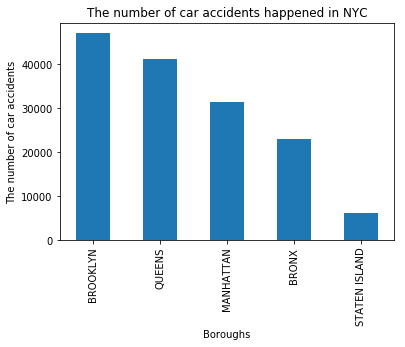

In [37]:
borough.value_counts().plot(kind = 'bar')
plt.title("The number of car accidents happened in NYC")
plt.ylabel('The number of car accidents')
plt.xlabel('Boroughs')
plt.show()

#### 2.2 The relation between time and the number of car accidents

The "TIME" column in the data shows the time that accidents happened. By combining borough and time information, we can find out what time most car accidents happened in one day and the difference between the number of car accidents happened in different boroughs at the same time. The time information in the data was down to minute. To make clearer comparison, the time was round to hour.

In [98]:
for i in range(len(data2018)):
    times = data2018['TIME'][i].split(":")
    mins = int(times[1])
    if mins > 30:
        hour = int(times[0])+1
    else:
        hour = int(times[0])
    data2018.at[i, 'TIME'] = hour
group = pd.DataFrame(data2018[['BOROUGH', 'TIME']])
group['count'] = [1]*len(group)

The heatmap was used to present the comparison result. As shown in the plot, the most accidents happened during "rush hour", between 2pm to 6pm. In the same time range, the most car accidents happened in Brooklyn, 3 to 5 times more than other boroughs. Moreover, We can see from the plot that besides the "rush hour", there was a peak value at 0am. 

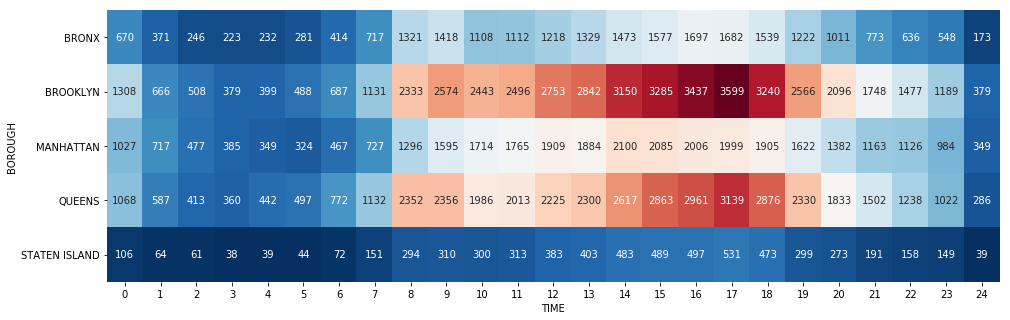

In [99]:
plt.figure(figsize = (16,5))
sns.heatmap(group.groupby(['BOROUGH', 'TIME'])['count'].sum().unstack(),annot=True, cbar=False, 
            fmt='.0f', cmap='RdBu_r')

### 3. The relation between the number of car accidents and population

According to the result from the comparion of the number of car accidents between boroughs, the ranking is very close to the ranking of population. To analysis the correlation between car accidents and population, the NYC population dataset was merged in.

In [208]:
population = pd.read_csv("https://data.cityofnewyork.us/resource/xywu-7bv9.csv")

The population dataset has a record or prediction of population in NYC for every ten years from 1950 to 2040. Since the data that was used to analysis car accidents was from 2018 and the closest data should be used to ensure accuracy, the population from 2020 was choosen.

To better make comparison, a decending order was used to present the ranking. As shown in the plot, the ranking of population in 2020 was same with the ranking of the number of car accidents.

/Users/rui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <BarContainer object of 5 artists> has a label of '_2020_boro_share_of_nyc_total' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


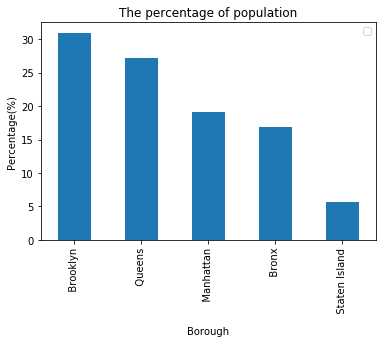

In [315]:
pData = pd.DataFrame(population).iloc[1:6]
pop2018 = pData[["_2020_boro_share_of_nyc_total", "borough"]]
pop2018 = pop2018.sort_values(by=['_2020_boro_share_of_nyc_total'], ascending = False)
pop2018.plot(kind = 'bar', x = "borough")
plt.title("The percentage of population")
plt.ylabel('Percentage(%)')
plt.xlabel('Borough')
plt.show()

To show the correlation more clearer, a percentage of car accidents column was added in the car accidents dataset.

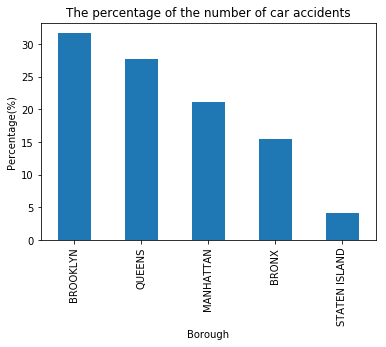

In [318]:
borough = data2018['BOROUGH']
counts = pd.DataFrame(borough.value_counts())
counts['accident_perc']= counts['BOROUGH']/counts['BOROUGH'].sum()*100
counts['accident_perc'].plot(kind = 'bar')
plt.title("The percentage of the number of car accidents")
plt.ylabel('Percentage(%)')
plt.xlabel('Borough')
plt.show()

To show the car accident rate and borough population in one plot, two columns were combined. As shown in the plot, the ranking is the same with small difference in the proportion. This result showed that population can influence the rate of car accident to some extent. Large population and population density may lead to more car accidents.

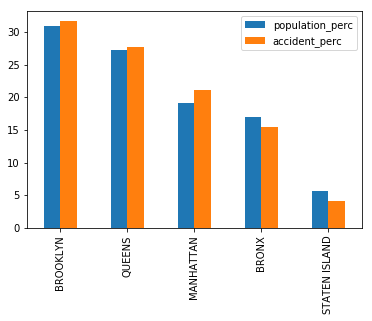

In [218]:
pop = pop2018["_2020_boro_share_of_nyc_total"].reset_index()
counts['population_perc'] = list(pop["_2020_boro_share_of_nyc_total"])
counts[['population_perc', 'accident_perc']].plot(kind = 'bar')

### 4. The influence of car type

The vehicle type column used different names represent same car type. For example, "sport utility / station wagon" and "station wagon/sport utility vehicle" both represent suv, "pick-up" and "puck-up truck" both represent box truck. Thus, the dictionary "carMap" was built to allocate car type for different names. This dictionary was used to change the vehicle type of all rows. The function "unityVehicleType" was built to loop through all rows to change corresponding name of the car type.

In [100]:
carMap = {"passenger vehicle": "passenger vehicle","sport utility / station wagon": "suv","sedan": "sedan","station wagon/sport utility vehicle": "suv","taxi": "taxi","pick-up truck": "pick-up","box truck": "truck","bus": "bus","tk": "truck","bu": "bus","motorcycle": "motorcycle","bike": "bike","van": "van","bicycle": "bike","tractor truck diesel": "tractor","vn": "van","convertible": "convertible","dump": "garbage truck","pk": "pick-up","ambulance": "ambulance","garbage or refuse": "truck","conv": "convertible","am": "ambulance","flat bed": "flat bed","carry all": "carry all","ambul": "ambulance","gg": "convertible","tractor truck gasoline": "tractor","fb": "van","tow truck / wrecker": "tow truck","ll": "convertible","tr": "truck","moped": "moped","motorscooter": "scooter","tanker": "tanker","chassis cab": "truck","trail": "tow truck","concrete mixer": "concrete mixer","truck": "truck","fire": "fire truck","refrigerated van": "refrigerated van","fire truck": "fire","cb": "taxi","motorbike": "motorcycle","armored truck": "armored truck","fdny": "fire truck","flat rack": "flat rack","tract": "tow truck","3-door": "hatchbacks","beverage truck": "beverage truck","fr": "fire truck","schoo": "school bus","elect": "electric car","usps": "delivery truck","tow t": "tow truck","scoot": "scooter","4 dr sedan": "sedan","forkl": "forkl","lift boom": "lift boom","utili": "suv","pedicab": "pedicab","deliv": "delivery truck","3d": "hatchbacks","firet": "fire truck","box t": "truck","school bus": "school bus","amb": "ambulance","motor": "motorcycle","ambu": "ambulance","freig": "refrigerated van","snow plow": "snow plow","uhaul": "truck","flat": "flat bed","garba": "garbage truck","mail": "delivery truck","tow": "tow truck","picku": "pick-up","suv": "suv","scooter": "scooter","2 dr sedan": "sedan","delv": "delivery truck","ups t": "delivery truck","scoo": "scooter","fedx": "delivery truck","mini": "minivan","horse": "horse","bicyc": "bike","dumps": "garbage truck","wagon": "suv","uhual": "truck","passa": "passenger vehicle","pick-": "pick-up"}

In [138]:
def unityVehicleType(data, typeMap):
    for i in range(len(data.index)):
        typeName = data['VEHICLE TYPE CODE 1'][i].lower()
        if typeName in typeMap:
            typeName = typeMap[typeName]
        data.at[i, 'VEHICLE TYPE CODE 1'] = typeName
    return data
data2018 = unityVehicleType(data2018, carMap)
data2018 = data2018[data2018['VEHICLE TYPE CODE 1'] != ""]

There were around 100 car types in the dataset and most of them only related to 1 car accident. So the car types that has less that 100 related car accidents were deleted to better show the result. 

In [140]:
vehicle = data2018['VEHICLE TYPE CODE 1']
vtype = vehicle.value_counts().to_frame().reset_index()
vtype.columns = ['type', 'count']
vtype = vtype[vtype['count']>100]
vtype

,type,count
0,suv,52356
1,sedan,46113
2,passenger vehicle,22810
3,taxi,7775
4,pick-up,4749
5,truck,3611
6,bus,2545
7,bike,1615
8,van,1243
9,motorcycle,773


A plot was made to visualize the counts. We can see from the plot that the top ten car types that related to the most car accidents were SUV, sedan, passenger vehicle, taxi, pick-up, truck, bus, bike, van, and motocycle. Although SUV related to the largest amount of car accidents, it doesn't mean that SUV cars were more likely to have car accident. Since SUV was one of the most popular car type, there were more SUV cars on the road than other types.

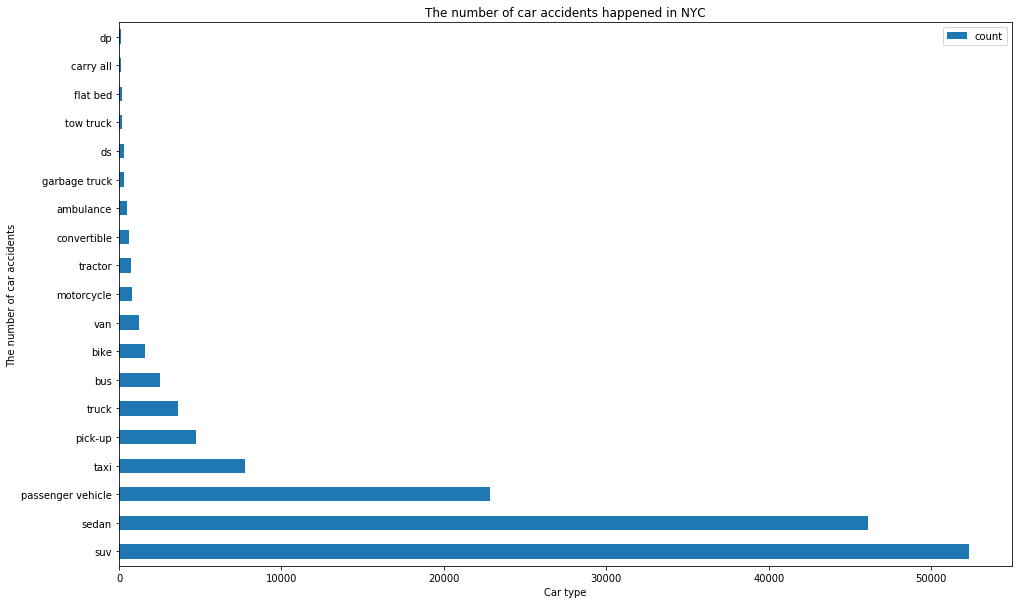

In [143]:
vtype.plot(kind = 'barh', figsize = (16,10), x ='type')
plt.title("The number of car accidents happened in NYC")
plt.ylabel('The number of car accidents')
plt.xlabel('Car type')
plt.show()

To take the total number of registered cars of related types into consideration, the dataset that recorded all vehicle registration information in New York State need to be merged. However, the dataset contains more than ten million rows and is too big to be merged. Thus the downloadNYCRMV function was used to extract data of related car types from the origin dataset and record the number of registration cars of all related types. This function can return a dictionary that has the total number of registered cars of different types. In this dataset, "SEDN", "2DSD" and "4DSD" all indicate sedan, and other car types all have different names. Thus a typeConvert map was used to combine data for every car type.

In [244]:
import collections
import urllib.parse
def downloadNYCRMV():
    url = 'https://data.ny.gov/resource/w4pv-hbkt.csv?'
    typeUrl = 'https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW YORK       &body_type=%s&$limit=10000000'
    classUrl = 'https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW YORK       &registration_class=%s&$limit=10000000'
    types = ['SEDN', 'SUBN', '4DSD', '2DSD', 'VAN ']
    classes = ['MOT', 'PAS']
    typeConvert = {'SEDN': 'sedan', 'SUBN': 'suv', '4DSD': 'sedan', '2DSD': 'sedan', 'TR/C': 'truck', 'SWT ': 'truck', 'PICK': 'pick-up', 'VAN ': 'van', 'MOT': 'motorcycle', 'PAS': 'passenger vehicle'}
    typeMap = collections.defaultdict(int)
    for t in types:
        query = {'city': 'NEW YORK       ', '$limit': '10000000'}
        print('Type: %s' % t)
        query['body_type'] = t
        rUrl = url + urllib.parse.urlencode(query)
        print(rUrl)
        data = pd.read_csv(rUrl)
        typeMap[typeConvert[t]] += len(data)
    for c in classes:
        query = {'city': 'NEW YORK       ', '$limit': '10000000'}
        print('Type: %s' % c)
        query['registration_class'] = c
        rUrl = url + urllib.parse.urlencode(query)
        print(rUrl)
        data = pd.read_csv(rUrl)
        typeMap[typeConvert[c]] += len(data)
    return typeMap
typeMap = downloadNYCRMV()

Type: SEDN
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&body_type=SEDN
Type: SUBN
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&body_type=SUBN
Type: 4DSD
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&body_type=4DSD
Type: 2DSD
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&body_type=2DSD
Type: VAN 
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&body_type=VAN+
Type: MOT
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&registration_class=MOT
Type: PAS
https://data.ny.gov/resource/w4pv-hbkt.csv?city=NEW+YORK+++++++&%24limit=10000000&registration_class=PAS


Below showed the return dictionary of the downloadNYCRMV function. The keys were car types and the values were the number of cars of every type.

In [256]:
typeMap

defaultdict(int,
            {'sedan': 84941,
             'suv': 122615,
             'van': 8153,
             'motorcycle': 7637,
             'passenger vehicle': 195845})

By using the total number of registered cars of every type, the car accident rate was calculated for each car type. A new column was added to the car accidents rate. The modified data was shown below. 

In [313]:
types = ["suv", "sedan", "van", "motorcycle", "passenger vehicle"]
carType = vtype[vtype["type"].isin(types)].reset_index()
carType = carType[['type', 'count']]
for i in range(len(carType)):
    carType.at[i,'rate'] = carType['count'][i]/typeMap[carType['type'][i]]
carType

,type,count,rate
0,suv,52356,0.426995
1,sedan,46113,0.542883
2,passenger vehicle,22810,0.116470
3,van,1243,0.152459
4,motorcycle,773,0.101218


Two graphs were ploted below. One is the plot of the number of car accidents of every car type, the other one is the car accident rate of every car type. As shown in the plots, the orders were different. After taking the total registered number into consideration, SUV was no longer the biggest one, instead, sedan became the car type that had highest car accident rate. Also, the order of passenger vehicle and van was changed. The ranking shows that 

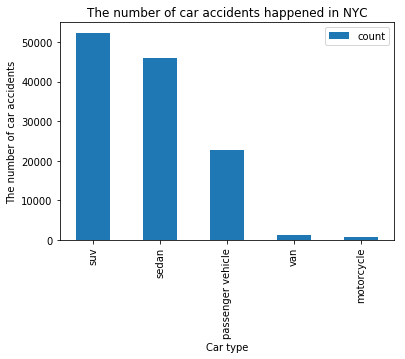

In [312]:
carType[['count','type']].plot(kind = 'bar', x ='type')
plt.title("The number of car accidents happened in NYC")
plt.ylabel('The number of car accidents')
plt.xlabel('Car type')
plt.show()

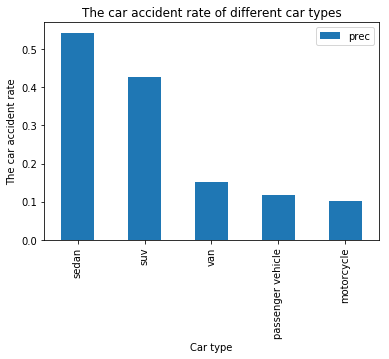

In [311]:
carTypePerc = carType[['rate','type']].sort_values(by = ['rate'], ascending = False)
carTypePerc[['rate','type']].plot(kind = 'bar', x ='type')
plt.title("The car accident rate of different car types")
plt.ylabel('The car accident rate')
plt.xlabel('Car type')
plt.show()